# Re-implementing procedure outlined in "Entity Profiling in Knowledge Graphs" (Zhang Et al.)
# This notebook will implement the candidate label creation step
Using a subset of wikidata related to Q44 ("beer")

In [68]:
import os

In [69]:
work_dir = "/Users/nicklein/Documents/grad_school/Research/data"

In [70]:
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(work_dir)
os.environ['DATA'] = "{}/Q44".format(work_dir)
os.environ['NAME'] = "Q44"
os.environ["OUT"] = "{}/Q44_profiler_output".format(work_dir)

Helper function for executing commands

In [71]:
def run_command(command, substitution_dictionary = {}):
    """Run a templetized command."""
    #cmd = command.replace("NAME", subset_name)
    for k, v in substitution_dictionary.items():
        cmd = cmd.replace(k, v)
    
    print(cmd)
    output = subprocess.run([cmd], shell=True, universal_newlines=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(output.stdout)
    print(output.stderr)

## Examples of using query command:
### Ex - Counting instances of <type, property, value> along with the property label

In [131]:
!kgtk query -i $DATA/$NAME.part.wikibase-item.tsv -i $DATA/$NAME.label.en.tsv --graph-cache $STORE \
--match 'item: (n1)-[l {label: p}]->(n2), item: (n1)-[:P31]->(type), label: (p)-[:label]->(lab)' \
--return 'distinct type as type, l.label as prop, n2 as value, count(n1) as count, lab as property_label' \
--where 'lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'type, count(n1) desc' \
--limit 5

type	prop	value	count	property_label
Q1066984	P1343	Q97879676	3	'described by source'@en
Q1066984	P1343	Q316838	2	'described by source'@en
Q1066984	P17	Q154195	2	'country'@en
Q1066984	P17	Q183	2	'country'@en
Q1066984	P17	Q2415901	2	'country'@en


### Ex - Counting property, value pairs for time properties

In [165]:
!kgtk query -i $DATA/$NAME.part.time.tsv -i $DATA/$NAME.label.en.tsv --graph-cache $STORE \
--match 'time: (n1)-[l {label: p}]->(n2), label: (p)-[:label]->(lab)' \
--return 'distinct l.label as prop, lab as property_label, kgtk_date_year(n2) as val, count(n1) as count' \
--where 'lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'count(n1) desc' \
--limit 5

prop	property_label	val	count
P571	'inception'@en	1991	20
P571	'inception'@en	1918	14
P571	'inception'@en	1989	8
P571	'inception'@en	1996	8
P571	'inception'@en	1821	6


### Ex- Counting property, value pairs for quantity properties

In [133]:
!kgtk query -i $DATA/$NAME.part.quantity.tsv -i $DATA/$NAME.label.en.tsv --graph-cache $STORE \
--match 'quantity: (n1)-[l {label: p}]->(n2), label: (p)-[:label]->(lab)' \
--return 'distinct l.label as prop, lab as property_label, n2 as value, count(n1) as count' \
--where 'lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'count(n1) desc' \
--limit 5

prop	property_label	value	count
P3000	'marriageable age'@en	+18Q24564698	56
P2997	'age of majority'@en	+18Q24564698	52
P1279	'inflation rate'@en	+1.7Q11229	41
P2884	'mains voltage'@en	+230Q25250	40
P1279	'inflation rate'@en	+1.8Q11229	38


# Outline of procedure:
**Goal**:<br>
We want to create candidate label sets including
- Attribute value labels (type, property, *attribute*)
- Realtional entity labels (type, property, *entity*)
- Attribute interval labels (type, property, *range of attribute values*)
- Relational attribute labels (type, property, *attribute or attribute range of another entity*)

To enable subsequent filtering of these labels, we also want to count:
- The number of entities of each type
- The number of entities that match each label (call these "positives")
    
**Steps**:

0. Create type-mapping
1. Count the number of entities of each type
    - *optional future step*: define type with P279 transitive closure in addition to P31. 
2. Create AVLs trivially from attribute files along with counts of the positive entities for each label
    - At this step, we should also contribute to a mapping of entities --> matching attribute labels to facilitate creating RALs in a later step  
3. Create RELs trivially from entity relation files along with counts of positive entities for each label
4. Create AILs by discretizing the AVLs we found, along with counts of positive entities for each label
    - This can be done using the counts that we already have
    - We'll likely try a naive approach at first such as hardcoding a bucket size for each numeric type we care about
    - At this step, we should also contribute to a mapping of entities --> matching attribute labels to facilitate creating RALs in a later step
    - **kind-of Issue:** in naive bucketing method, run into mod operator doesn't seem to be supported in query
    - **TODO:** make table of type/property --> low_bound/up_bound buckets to be used instead of using mod operator.
    - to do the above it would be nice to have some -/+ infinity value. Otherwise, need logic like "WHERE low_bound is null OR low_bound < value" - this might work?
5. Create RALs by using the REL table and the entities --> attribute labels table that built in steps 2 and 4. Also keep track of counts of positive entities for each label
6. Filter the labels using a simple heuristic based on counts
    - **TODO**
    
*Misc issues encountered*
- Finding that some of the kgtk type interpretation functions aren't recognized (e.g. I can use kgtk_date_year no problem, but kgtk_quantity_number_int not recognized)
- Is there a way to make an id by concatenating multiple values in the row? I found stringify, but not sure how to concatenate strings.
    - could be useful for giving labels ids and then we could look up what labels an entity had by their id rather than type prop and value
    - --> yes. kgtk add-id
- kgtk rename-columns doesn't always work when input file == output file. Getting around this right now by creating extra temp files... 
- mod operator not supported in a query?
- is there a notion of infinity/-infinity that I can put in a kgtk file?

## 0. Create type mapping
Using P31 only for now, but can add P279* as well later

In [361]:
!kgtk filter -p ' ; P31 ; ' -i $DATA/$NAME.part.wikibase-item.tsv -o $OUT/$NAME.type_mapping.tsv

In [638]:
!head -5 $OUT/$NAME.type_mapping.tsv | column -t -s $'\t'

id              node1     label  node2
Q1000597-P31-1  Q1000597  P31    Q3957
Q1011-P31-2     Q1011     P31    Q112099
Q1011-P31-1     Q1011     P31    Q3624078
Q1019-P31-2     Q1019     P31    Q112099


## 1. Count number of entities of each type:

In [589]:
!kgtk query -i $OUT/$NAME.type_mapping.tsv -i $DATA/$NAME.label.en.tsv -o $OUT/$NAME.entity_counts_per_type_temp.tsv --graph-cache $STORE \
--match 'type: (n1)-[]->(type), label: (type)-[:label]->(lab)' \
--return 'distinct type as type, lab as type_label, count(distinct n1) as count, "_" as id' \
--where 'lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'count(distinct n1) desc' \

In [590]:
!kgtk rename-columns -i $OUT/$NAME.entity_counts_per_type_temp.tsv -o $OUT/$NAME.entity_counts_per_type_temp1.tsv \
--old-columns type type_label count --new-columns node1 label node2 

In [591]:
!kgtk add-id -i $OUT/$NAME.entity_counts_per_type_temp1.tsv \
-o $OUT/$NAME.entity_counts_per_type.tsv --overwrite-id

In [637]:
!head -5 $OUT/$NAME.entity_counts_per_type.tsv | column -t -s $'\t'

node1     label                 node2  id
Q131734   'brewery'@en          87     E1
Q3624078  'sovereign state'@en  69     E2
Q4830453  'business'@en         50     E3
Q6256     'country'@en          26     E4


## 2. Create AVLs with counts of positive entities
### Keep track of entities --> matching attribute labels for future use
### Keep numeric valued labels and non-numeric valued labels separate to help with discretization at a later step


### todo - use a loop to do this for all types we care about (e.g. day / month / year) currently just doing this for years

### strings
Creating mapping of entity --> string attribute labels

In [728]:
!kgtk query -i $OUT/$NAME.type_mapping.tsv -i $DATA/$NAME.part.string.tsv -i $DATA/$NAME.label.en.tsv \
-o $OUT/$NAME.entity_attribute_labels_string_temp.tsv --graph-cache $STORE \
--match 'string: (n1)-[l {label:p}]->(n2), type: (n1)-[]->(type), label: (p)-[:label]->(lab)' \
--return 'distinct n1 as entity, type as type, p as prop, n2 as value, lab as property_label, "_" as id' \
--where 'lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'n1'

In [729]:
!kgtk rename-columns -i $OUT/$NAME.entity_attribute_labels_string_temp.tsv \
-o $OUT/$NAME.entity_attribute_labels_string_temp1.tsv \
--old-columns type prop value --new-columns node1 label node2

In [730]:
!kgtk add-id -i $OUT/$NAME.entity_attribute_labels_string_temp1.tsv \
-o $OUT/$NAME.entity_attribute_labels_string.tsv --overwrite-id

In [731]:
!head -5 $OUT/$NAME.entity_attribute_labels_string.tsv | column -t -s $'\t'

entity    node1  label  node2                property_label           id
Q1000597  Q3957  P281   "DE14"               'postal code'@en         E1
Q1000597  Q3957  P373   "Burton upon Trent"  'Commons category'@en    E2
Q1000597  Q3957  P473   "01283"              'local dialing code'@en  E3
Q1000597  Q3957  P613   "SK245225"           'OS grid reference'@en   E4


Aggregating distinct labels w/ positive entity counts

In [732]:
!kgtk query -i $OUT/$NAME.entity_attribute_labels_string.tsv \
-o $OUT/$NAME.candidate_labels_avl_string_temp.tsv --graph-cache $STORE \
--match 'labels: (type)-[l {label:prop, property_label:lab, entity:e}]->(val)' \
--return 'distinct type as type, prop as prop, val as value, count(distinct e) as positives, lab as property_label, "_" as id' \
--order-by 'count(distinct e) desc'

In [733]:
!kgtk rename-columns -i $OUT/$NAME.candidate_labels_avl_string_temp.tsv \
-o $OUT/$NAME.candidate_labels_avl_string_temp1.tsv \
--old-columns type prop value --new-columns node1 label node2

In [734]:
!kgtk remove-columns -c "id" -i $OUT/$NAME.candidate_labels_avl_string_temp1.tsv \
-o $OUT/$NAME.candidate_labels_avl_string_temp2.tsv

In [735]:
!kgtk add-id -i $OUT/$NAME.candidate_labels_avl_string_temp2.tsv -o $OUT/$NAME.candidate_labels_avl_string.tsv

In [736]:
!head -5 $OUT/$NAME.candidate_labels_avl_string.tsv | column -t -s $'\t'

node1     label  node2    positives  property_label     id
Q3624078  P3238  "0"      34         'trunk prefix'@en  E1
Q3624078  P3238  novalue  14         'trunk prefix'@en  E2
Q6256     P3238  "0"      12         'trunk prefix'@en  E3
Q179164   P3238  "0"      9          'trunk prefix'@en  E4


### Times

Looking at what precisions we need to deal with...

In [634]:
!kgtk query -i $DATA/$NAME.part.time.tsv $DATA/$NAME.label.en.tsv\
--graph-cache $STORE \
--match 'time: (n1)-[l {label:p}]->(n2), label: (p)-[:label]->(lab)' \
--return 'distinct kgtk_date_precision(n2) as precisions, count(n1) as count' \
--limit 10 \
| column -t -s $'\t'

precisions  count
6           12
7           40
8           12
9           697
10          48
11          469


From the above, we have several precisions below precision of year=9. We don't have kgtk type interpretation functions for these granularities, so for now we'll interpret them all as years. We also don't have a kgtk function for month and year - just month alone. We'll use the date (with day, month, and year) for precisions finer than a year. **Note** we may want to find a way to eventually recover the original intended type.

#### precision = year or broader
We interpret these as years

In [869]:
!kgtk query -i $OUT/$NAME.type_mapping.tsv -i $DATA/$NAME.part.time.tsv -i $DATA/$NAME.label.en.tsv \
-o $OUT/$NAME.entity_attribute_labels_time.year_temp.tsv --graph-cache $STORE \
--match 'time: (n1)-[l {label:p}]->(n2), type: (n1)-[]->(type), label: (p)-[:label]->(p_lab), label: (type)-[:label]->(t_lab)' \
--return 'distinct n1 as entity, type as type, p as prop, kgtk_date_year(n2) as value, t_lab as type_label, p_lab as property_label, "_" as id' \
--where 't_lab.kgtk_lqstring_lang_suffix = "en" AND p_lab.kgtk_lqstring_lang_suffix = "en" AND kgtk_date_precision(n2) <= 9' \
--order-by 'n1'

In [870]:
!kgtk rename-columns -i $OUT/$NAME.entity_attribute_labels_time.year_temp.tsv \
-o $OUT/$NAME.entity_attribute_labels_time.year_temp1.tsv \
--old-columns type prop value --new-columns node1 label node2

In [871]:
!kgtk remove-columns -c "id" -i $OUT/$NAME.entity_attribute_labels_time.year_temp1.tsv \
-o $OUT/$NAME.entity_attribute_labels_time.year_temp2.tsv

In [872]:
!kgtk add-id -i $OUT/$NAME.entity_attribute_labels_time.year_temp2.tsv \
-o $OUT/$NAME.entity_attribute_labels_time.year.tsv

In [873]:
!head -5 $OUT/$NAME.entity_attribute_labels_time.year.tsv | column -t -s $'\t'

entity     node1     label  node2  type_label            property_label  id
Q1019      Q112099   P571   1960   'island nation'@en    'inception'@en  E1
Q1019      Q3624078  P571   1960   'sovereign state'@en  'inception'@en  E2
Q10272528  Q4830453  P571   1872   'business'@en         'inception'@en  E3
Q1033      Q3624078  P571   1960   'sovereign state'@en  'inception'@en  E4


Aggregating distinct labels w/ positive entity counts

In [723]:
!kgtk query -i $OUT/$NAME.entity_attribute_labels_time.year.tsv \
-o $OUT/$NAME.candidate_labels_avl_time.year_temp.tsv --graph-cache $STORE \
--match 'labels: (n1)-[l {label:p, property_label:lab, entity:e}]->(val)' \
--return 'distinct n1 as type, p as prop, val as value, count(distinct e) as positives, lab as property_label, "_" as id' \
--order-by 'count(distinct e) desc'

In [724]:
!kgtk rename-columns -i $OUT/$NAME.candidate_labels_avl_time.year_temp.tsv \
-o $OUT/$NAME.candidate_labels_avl_time.year_temp1.tsv \
--old-columns type prop value --new-columns node1 label node2

In [725]:
!kgtk remove-columns -c "id" -i $OUT/$NAME.candidate_labels_avl_time.year_temp1.tsv \
-o $OUT/$NAME.candidate_labels_avl_time.year_temp2.tsv

In [726]:
!kgtk add-id -i $OUT/$NAME.candidate_labels_avl_time.year_temp2.tsv \
-o $OUT/$NAME.candidate_labels_avl_time.year.tsv

In [727]:
!head -5 $OUT/$NAME.candidate_labels_avl_time.year.tsv | column -t -s $'\t'

node1     label  node2  positives  property_label  id
Q3624078  P571   1991   3          'inception'@en  E1
Q123480   P571   1991   2          'inception'@en  E2
Q131734   P571   1985   2          'inception'@en  E3
Q131734   P571   1996   2          'inception'@en  E4


#### precision finer than a year
we interpret these as dates with day, month, year

In [737]:
!kgtk query -i $OUT/$NAME.type_mapping.tsv -i $DATA/$NAME.part.time.tsv -i $DATA/$NAME.label.en.tsv \
-o $OUT/$NAME.entity_attribute_labels_time.date_temp.tsv --graph-cache $STORE \
--match 'time: (n1)-[l {label:p}]->(n2), type: (n1)-[]->(type), label: (p)-[:label]->(lab)' \
--return 'distinct n1 as entity, type as type, p as prop, kgtk_date_date(n2) as value, lab as property_label, "_" as id' \
--where 'lab.kgtk_lqstring_lang_suffix = "en" AND kgtk_date_precision(n2) > 9' \
--order-by 'n1'

In [738]:
!kgtk rename-columns -i $OUT/$NAME.entity_attribute_labels_time.date_temp.tsv \
-o $OUT/$NAME.entity_attribute_labels_time.date_temp1.tsv \
--old-columns type prop value --new-columns node1 label node2

In [739]:
!kgtk remove-columns -c "id" -i $OUT/$NAME.entity_attribute_labels_time.date_temp1.tsv \
-o $OUT/$NAME.entity_attribute_labels_time.date_temp2.tsv

In [740]:
!kgtk add-id -i $OUT/$NAME.entity_attribute_labels_time.date_temp2.tsv \
-o $OUT/$NAME.entity_attribute_labels_time.date.tsv

In [741]:
!head -5 $OUT/$NAME.entity_attribute_labels_time.date.tsv | column -t -s $'\t'

entity    node1     label  node2        property_label  id
Q1011     Q112099   P571   ^1975-07-05  'inception'@en  E1
Q1011     Q3624078  P571   ^1975-07-05  'inception'@en  E2
Q1020773  Q3957     P571   ^1892-10-12  'inception'@en  E3
Q1020773  Q902814   P571   ^1892-10-12  'inception'@en  E4


Aggregating distinct labels w/ positive entity counts

In [742]:
!kgtk query -i $OUT/$NAME.entity_attribute_labels_time.date.tsv \
-o $OUT/$NAME.candidate_labels_avl_time.date_temp.tsv --graph-cache $STORE \
--match 'labels: (n1)-[l {label:p, property_label:lab, entity:e}]->(val)' \
--return 'distinct n1 as type, p as prop, val as value, count(distinct e) as positives, lab as property_label, "_" as id' \
--order-by 'count(distinct e) desc'

In [743]:
!kgtk rename-columns -i $OUT/$NAME.candidate_labels_avl_time.date_temp.tsv \
-o $OUT/$NAME.candidate_labels_avl_time.date_temp1.tsv \
--old-columns type prop value --new-columns node1 label node2

In [744]:
!kgtk remove-columns -c "id" -i $OUT/$NAME.candidate_labels_avl_time.date_temp1.tsv \
-o $OUT/$NAME.candidate_labels_avl_time.date_temp2.tsv

In [745]:
!kgtk add-id -i $OUT/$NAME.candidate_labels_avl_time.date_temp2.tsv \
-o $OUT/$NAME.candidate_labels_avl_time.date.tsv

In [746]:
!head -5 $OUT/$NAME.candidate_labels_avl_time.date.tsv | column -t -s $'\t'

node1     label  node2         positives  property_label                        id
Q1066984  P1249  ^1158-06-14   1          'time of earliest written record'@en  E1
Q1093829  P571   ^1790-07-16   1          'inception'@en                        E2
Q112099   P571   ^-0660-02-11  1          'inception'@en                        E3
Q112099   P571   ^1898-12-10   1          'inception'@en                        E4


## Quantities
Not using a kgtk literal function for now so we can keep the units attached to the values. Otherwise, could interpret everything as a number and drop the units. Seems like we need the units though.

In [747]:
!kgtk query -i $OUT/$NAME.type_mapping.tsv -i $DATA/$NAME.part.quantity.tsv -i $DATA/$NAME.label.en.tsv \
-o $OUT/$NAME.entity_attribute_labels_quantity_temp.tsv --graph-cache $STORE \
--match 'quantity: (n1)-[l {label:p}]->(n2), type: (n1)-[]->(type), label: (p)-[:label]->(lab)' \
--return 'distinct n1 as entity, type as type, p as prop, n2 as value, lab as property_label, "_" as id' \
--where 'lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'n1'

In [748]:
!kgtk rename-columns -i $OUT/$NAME.entity_attribute_labels_quantity_temp.tsv \
-o $OUT/$NAME.entity_attribute_labels_quantity_temp1.tsv \
--old-columns type prop value --new-columns node1 label node2

In [749]:
!kgtk remove-columns -c "id" -i $OUT/$NAME.entity_attribute_labels_quantity_temp1.tsv \
-o $OUT/$NAME.entity_attribute_labels_quantity_temp2.tsv

In [750]:
!kgtk add-id -i $OUT/$NAME.entity_attribute_labels_quantity_temp2.tsv \
-o $OUT/$NAME.entity_attribute_labels_quantity.tsv

In [751]:
!head -5 $OUT/$NAME.entity_attribute_labels_quantity.tsv | column -t -s $'\t'

entity    node1     label  node2   property_label                id
Q1000597  Q3957     P1082  +75074  'population'@en               E1
Q1011     Q112099   P1081  +0.570  'Human Development Index'@en  E2
Q1011     Q3624078  P1081  +0.570  'Human Development Index'@en  E3
Q1011     Q112099   P1081  +0.572  'Human Development Index'@en  E4


Aggregating distinct labels w/ positive entity counts

In [752]:
!kgtk query -i $OUT/$NAME.entity_attribute_labels_quantity.tsv \
-o $OUT/$NAME.candidate_labels_avl_quantity_temp.tsv --graph-cache $STORE \
--match 'labels: (n1)-[l {label:p, property_label:lab, entity:e}]->(val)' \
--return 'distinct n1 as type, p as prop, val as value, count(distinct e) as positives, lab as property_label, "_" as id' \
--order-by 'count(distinct e) desc'

In [753]:
!kgtk rename-columns -i $OUT/$NAME.candidate_labels_avl_quantity_temp.tsv \
-o $OUT/$NAME.candidate_labels_avl_quantity_temp1.tsv \
--old-columns type prop value --new-columns node1 label node2

In [754]:
!kgtk remove-columns -c "id" -i $OUT/$NAME.candidate_labels_avl_quantity_temp1.tsv \
-o $OUT/$NAME.candidate_labels_avl_quantity_temp2.tsv

In [755]:
!kgtk add-id -i $OUT/$NAME.candidate_labels_avl_quantity_temp2.tsv \
-o $OUT/$NAME.candidate_labels_avl_quantity.tsv

In [756]:
!head -5 $OUT/$NAME.candidate_labels_avl_quantity.tsv | column -t -s $'\t'

node1     label  node2         positives  property_label         id
Q3624078  P3000  +18Q24564698  54         'marriageable age'@en  E1
Q3624078  P2997  +18Q24564698  51         'age of majority'@en   E2
Q3624078  P2884  +230Q25250    38         'mains voltage'@en     E3
Q3624078  P1279  +1.7Q11229    25         'inflation rate'@en    E4


### Combining entity --> attribute label mappings to single table

In [577]:
!kgtk cat \
-i $OUT/$NAME.entity_attribute_labels_string.tsv \
-i $OUT/$NAME.entity_attribute_labels_time.year.tsv \
-i $OUT/$NAME.entity_attribute_labels_time.date.tsv \
-i $OUT/$NAME.entity_attribute_labels_quantity.tsv \
-o $OUT/$NAME.entity_attribute_labels_all.tsv

## 3. Create RELs with counts of positive entities

In [478]:
!kgtk query -i $DATA/$NAME.part.wikibase-item.tsv -i $OUT/$NAME.type_mapping.tsv -i $DATA/$NAME.label.en.tsv \
-o $OUT/$NAME.candidate_labels_rel_item_temp.tsv --graph-cache $STORE \
--match 'item: (n1)-[l {label:p}]->(n2), type: (n1)-[]->(type), label: (p)-[:label]->(lab)' \
--return 'distinct type as type, p as prop, n2 as value, count(distinct n1) as positives, lab as property_label, "_" as id' \
--where 'lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'count(distinct n1) desc'

In [479]:
!kgtk rename-columns -i $OUT/$NAME.candidate_labels_rel_item_temp.tsv \
-o $OUT/$NAME.candidate_labels_rel_item_temp1.tsv \
--old-columns type prop value --new-columns node1 label node2

In [480]:
!kgtk remove-columns -c "id" -i $OUT/$NAME.candidate_labels_rel_item_temp1.tsv \
-o $OUT/$NAME.candidate_labels_rel_item_temp2.tsv

In [481]:
!kgtk add-id -i $OUT/$NAME.candidate_labels_rel_item_temp2.tsv \
-o $OUT/$NAME.candidate_labels_rel_item.tsv

In [627]:
!head -5 $OUT/$NAME.candidate_labels_rel_item.tsv | column -t -s $'\t'

node1     label  node2    positives  property_label            id
Q131734   P452   Q869095  77         'industry'@en             E1
Q3624078  P463   Q1065    68         'member of'@en            E2
Q3624078  P463   Q7817    67         'member of'@en            E3
Q3624078  P530   Q183     67         'diplomatic relation'@en  E4


## 4. Create AILs with counts of positive entities
### 4.a. Keep track of entities --> matching attribute labels for future use


Just implementing a naive hard-coded bucket-size at first for time.date attribute labels

**issue:** mod operator doesn't seem to be supported here..

**TODO:** make table of type/property --> low_bound/up_bound buckets to be used below instead.

**issue:** to do the above it would be nice to have some -/+ infinity value. Otherwise, need logic like "WHERE low_bound is null OR low_bound < value" - this might work?

In [639]:
!echo $OUT/$NAME.entity_attribute_labels_time.year.tsv

/Users/nicklein/Documents/grad_school/Research/data/Q44_profiler_output/Q44.entity_attribute_labels_time.year.tsv


    node2  zeros
2    1872      0
9    1988      0
11   1847      0
14   1769      0
17   1698      0
(43, 2)


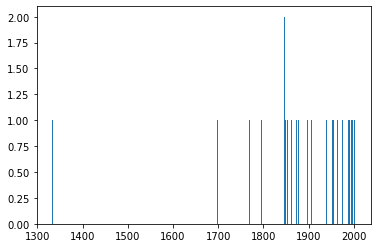

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
     node2  zeros
2     1872      0
9     1988      0
11    1847      0
14    1769      0
17    1698      0
..     ...    ...
257   2000      0
262   1989      0
264   1889      0
274   1990      0
279   1846      0

[43 rows x 2 columns]
Estimated number of clusters: 13
Estimated number of noise points: 0


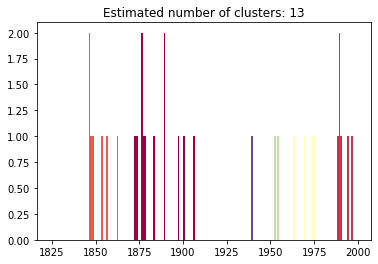

In [868]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

df = pd.read_csv("/Users/nicklein/Documents/grad_school/Research/data/Q44_profiler_output/Q44.entity_attribute_labels_time.year.tsv", delimiter='\t')
l_type = "Q4830453"
l_prop = "P571"
df["zeros"]=0

values_w_0s = df.loc[(df["node1"] == l_type) & (df["label"] == l_prop), ["node2", "zeros"]]
values = values_w_0s.loc[:,"node2"]
print(values_w_0s.head())
print(values_w_0s.shape)
plt.hist(values, bins = range(values.min()-1, values.max() + 1, 1))
plt.show()

db = DBSCAN(eps=8, min_samples=1).fit(values_w_0s)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
print(db.core_sample_indices_)
print(values_w_0s.iloc[db.core_sample_indices_])
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = values.loc[class_member_mask]
    plt.hist(xy, color=tuple(col), bins = range(1825, 2000, 1))

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Bucketing all year attributes to 5 year ranges

In [858]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#TODO - either make this a function with filename and bucket_size params, or get the filename using environment variables that are already defined
in_file = "/Users/nicklein/Documents/grad_school/Research/data/Q44_profiler_output/Q44.entity_attribute_labels_time.year.tsv"
out_file = "/Users/nicklein/Documents/grad_school/Research/data/Q44_profiler_output/Q44.entity_attribute_labels_time.year_bucketed.tsv"

df = pd.read_csv(in_file, delimiter='\t')
bucket_size = 5

vals = df.loc[:,"node2"]

low_ends = vals - (vals % bucket_size)
high_ends = low_ends + bucket_size - 1

# TODO - if we want to have open-ended ranges at the min and max buckets, need to do this per distinct type, property
#        i.e. loop through each distinct type, property combination
# min_val = vals.min()
# max_val = vals.max()
# min_low_end = min_val - (min_val % bucket_size)
# max_high_end = max_val - (max_val % bucket_size) + bucket_size - 1

# low_ends = ["" if v == min_low_end else v for v in low_ends]
# high_ends = ["" if v == max_high_end else v for v in high_ends]

df.insert(loc = df.columns.get_loc("node2") + 1, column = "lower_bound", value = low_ends)
df.insert(loc = df.columns.get_loc("lower_bound") + 1, column = "upper_bound", value = high_ends)

df.to_csv(path_or_buf = out_file, sep = '\t')


Aggregating distinct interval labels with positive entity counts

In [859]:
!kgtk query -i $OUT/$NAME.entity_attribute_labels_time.year_bucketed.tsv \
--graph-cache $STORE \
--match 'labels: (type)-[l {label:prop, property_label:lab, entity:e, lower_bound:lb, upper_bound:ub}]->(val)' \
--return 'type as type, prop as prop, lb as lower_bound, ub as upper_bound, count(e) as positives, lab as property_label, "_" as id' \
--order-by 'count(e) desc' \
--limit 5 \
| column -t -s $'\t'

type      prop  lower_bound  upper_bound  positives  property_label  id
Q131734   P571  1985         1989         5          'inception'@en  _
Q3624078  P571  1990         1994         4          'inception'@en  _
Q4830453  P571  1845         1849         4          'inception'@en  _
Q4830453  P571  1875         1879         4          'inception'@en  _
Q131734   P571  1995         1999         3          'inception'@en  _


## 5. Create RALs with counts of positive entities

Here is an idea of what kind of values we should find (creating RALs from scratch for string attributes only)

In [626]:
!kgtk query -i $DATA/$NAME.part.wikibase-item.tsv -i $DATA/$NAME.part.string.tsv \
-i $OUT/$NAME.type_mapping.tsv -i $DATA/$NAME.label.en.tsv --graph-cache $STORE \
--match 'item: (n1)-[l1 {label:p1}]->(n2), type: (n1)-[]->(type1), label: (p1)-[:label]->(lab1), string: (n2)-[l2 {label:p2}]->(n3), type: (n2)-[]->(type2), label: (p2)-[:label]->(lab2)' \
--return 'distinct type1 as type1, p1 as prop1, type2 as type2, p2 as prop2, n3 as value, count(distinct n1) as positives, lab1 as prop1_label, lab2 as prop2_label' \
--where 'lab1.kgtk_lqstring_lang_suffix = "en"' \
--where 'lab2.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'count(distinct n1) desc' \
--limit 5 \
| column -t -s $'\t'

type1     prop1  type2     prop2  value           positives  prop1_label               prop2_label
Q131734   P452   Q8148     P373   "Beer brewing"  77         'industry'@en             'Commons category'@en
Q3624078  P530   Q3624078  P3238  "0"             68         'diplomatic relation'@en  'trunk prefix'@en
Q3624078  P530   Q4209223  P3238  "0"             68         'diplomatic relation'@en  'trunk prefix'@en
Q3624078  P530   Q43702    P3238  "0"             68         'diplomatic relation'@en  'trunk prefix'@en
Q3624078  P530   Q619610   P3238  "0"             68         'diplomatic relation'@en  'trunk prefix'@en


**NOTE:** It looks like having all of the entity --> labels mappings together in one file would be nice here. I don't think there is a need to keep these separate? Maybe keep AVL and AIL separate.

Now using the REL table and the entities --> attribute labels table that we built in steps 2 and 4. Also keep track of counts of positive entities for each label

Trying to reuse RELs, however, when counting positives, we would need to sum each num_pos that matches the line - not sure how to do this, so the below won't capture when type1 --> x1 and type1 --> x2 resolve to be the same label: i.e. type1 --> typex --> val. See further down for alternate solution.

In [624]:
!kgtk query -i $OUT/$NAME.candidate_labels_rel_item.tsv -i $OUT/$NAME.entity_attribute_labels_string.tsv \
--graph-cache $STORE \
--match 'rel: (t1)-[l1 {label:p1, positives:num_pos}]->(v1), entity_attribute: (t2)-[l {entity:v1, label:p2}]->(v2)' \
--return 't1 as type, p1 as prop, t2 as value_type, p2 as value_prop, v2 as value_val, num_pos as positives, "_" as id' \
--order-by "kgtk_quantity_number_int(num_pos) desc" \
--limit 5 \
| column -t -s $'\t'

type      prop  value_type  value_prop  value_val       positives  id
Q131734   P452  Q8148       P373        "Beer brewing"  77         _
Q3624078  P530  Q3624078    P2258       "262"           67         _
Q3624078  P530  Q3624078    P2572       "Deutschland"   67         _
Q3624078  P530  Q3624078    P2979       "211"           67         _
Q3624078  P530  Q3624078    P2979       "218"           67         _


This way should work.

In [625]:
!kgtk query -i $DATA/$NAME.part.wikibase-item.tsv -i $OUT/$NAME.type_mapping.tsv \
-i $OUT/$NAME.entity_attribute_labels_string.tsv --graph-cache $STORE \
--match 'item: (n1)-[l1 {label:p1}]->(n2), type: (n1)-[]->(t1), entity_attribute: (t2)-[l2 {label:p2, entity:n2}]->(val)' \
--return 't1 as type1, p1 as prop1, t2 as type2, p2 as prop2, val as value, count(distinct n1) as positives, "_" as id' \
--order-by "count(distinct n1) desc" \
--limit 5 \
| column -t -s $'\t'

type1     prop1  type2     prop2  value           positives  id
Q131734   P452   Q8148     P373   "Beer brewing"  77         _
Q3624078  P530   Q3624078  P3238  "0"             68         _
Q3624078  P530   Q4209223  P3238  "0"             68         _
Q3624078  P530   Q43702    P3238  "0"             68         _
Q3624078  P530   Q619610   P3238  "0"             68         _


And now doing this for all attribute types:

In [623]:
!kgtk query -i $DATA/$NAME.part.wikibase-item.tsv -i $OUT/$NAME.type_mapping.tsv -i $DATA/$NAME.label.en.tsv \
-i $OUT/$NAME.entity_attribute_labels_all.tsv --graph-cache $STORE \
--match 'item: (n1)-[l1 {label:p1}]->(n2), type: (n1)-[]->(t1), entity_attribute: (t2)-[l2 {label:p2, entity:n2}]->(val), label: (p2)-[:label]->(lab2)' \
--return 't1 as type1, p1 as prop1, t2 as type2, p2 as prop2, lab2 as prop2_label, val as value, count(distinct n1) as positives, "_" as id' \
--order-by "count(distinct n1) desc" \
--where 'lab2.kgtk_lqstring_lang_suffix = "en"' \
--limit 5 \
| column -t -s $'\t'

type1     prop1  type2     prop2  prop2_label                   value           positives  id
Q131734   P452   Q8148     P373   'Commons category'@en         "Beer brewing"  77         _
Q131734   P452   Q8148     P580   'start time'@en               -3500           77         _
Q3624078  P530   Q3624078  P1081  'Human Development Index'@en  +0.801          68         _
Q3624078  P530   Q3624078  P1081  'Human Development Index'@en  +0.809          68         _
Q3624078  P530   Q3624078  P1081  'Human Development Index'@en  +0.814          68         _


## 6. Filtering candidate labels
Simple rule-based filter to remove labels that are trivially either unrepresentative or indistinctive

In [622]:
!kgtk query -i $OUT/$NAME.entity_counts_per_type.tsv -i $OUT/$NAME.candidate_labels_avl_string.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, property_label:lab}]->(val), counts_per_type: (type)-[]->(count)' \
--return 'type as type, prop as prop, val as val, lab as prop_label, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, "_" as id' \
--where 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) > 0.1 AND kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) < 0.9' \
--limit 5 \
| column -t -s $'\t'

type      prop   val      prop_label         support              id
Q3624078  P3238  "0"      'trunk prefix'@en  0.4927536231884058   _
Q3624078  P3238  novalue  'trunk prefix'@en  0.2028985507246377   _
Q6256     P3238  "0"      'trunk prefix'@en  0.46153846153846156  _
Q6256     P3238  novalue  'trunk prefix'@en  0.23076923076923078  _
Q6256     P3238  "8"      'trunk prefix'@en  0.11538461538461539  _


In [ ]:
$OUT/$NAME.candidate_labels_avl_string.tsv
$OUT/$NAME.candidate_labels_avl_time.year.tsv
$OUT/$NAME.candidate_labels_avl_time.date.tsv
$OUT/$NAME.candidate_labels_avl_quantity.tsv

In [621]:
!head -5 $OUT/$NAME.entity_counts_per_type.tsv | column -t -s $'\t'

node1     label                 node2  id
Q131734   'brewery'@en          87     E1
Q3624078  'sovereign state'@en  69     E2
Q4830453  'business'@en         50     E3
Q6256     'country'@en          26     E4
